In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from collections import deque
import heapq
import time
from IPython.display import display, clear_output
import copy

Grid created: 8x8
Start: (1, 1), Target: (6, 6)


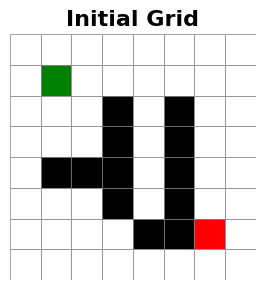

In [2]:
class GridWorld:
    def __init__(self, rows=8, cols=8):
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols), dtype=int)
        
        self.EMPTY = 0
        self.WALL = 1
        self.START = 2
        self.TARGET = 3
        self.VISITED = 4
        self.PATH = 5
        self.FRONTIER = 6
        
        self.start = (1, 1)
        self.target = (6, 6)
        
        self.reset_grid()
        
    def reset_grid(self):
        self.grid = np.zeros((self.rows, self.cols), dtype=int)
        
        for i in range(2, 6):
            self.grid[i, 3] = self.WALL
            self.grid[i, 5] = self.WALL
        
        for j in range(1, 4):
            self.grid[4, j] = self.WALL
            
        for j in range(4, 7):
            self.grid[6, j] = self.WALL
        
        self.grid[self.start[0], self.start[1]] = self.START
        self.grid[self.target[0], self.target[1]] = self.TARGET
    
    def get_neighbors(self, pos):
        row, col = pos
        neighbors = []
        
        moves = [
            (-1, 0),
            (0, 1),
            (1, 0),
            (1, 1),
            (0, -1),
            (-1, -1)
        ]
        
        for dr, dc in moves:
            new_row, new_col = row + dr, col + dc
            
            if (0 <= new_row < self.rows and 
                0 <= new_col < self.cols and 
                self.grid[new_row, new_col] != self.WALL):
                
                if abs(dr) == 1 and abs(dc) == 1:
                    if (self.grid[row + dr, col] != self.WALL and 
                        self.grid[row, col + dc] != self.WALL):
                        neighbors.append((new_row, new_col))
                else:
                    neighbors.append((new_row, new_col))
        
        return neighbors
    
    def get_cost(self, pos1, pos2):
        if abs(pos1[0] - pos2[0]) == 1 and abs(pos1[1] - pos2[1]) == 1:
            return 1.414
        return 1.0
    
    def visualize(self, title="Grid World", visited_order=None, frontier=None, final_path=None):
        fig, ax = plt.subplots(figsize=(3, 3))
        
        colors = {
            self.EMPTY: 'white',
            self.WALL: 'black',
            self.START: 'green',
            self.TARGET: 'red',
            self.VISITED: 'lightblue',
            self.PATH: 'yellow',
            self.FRONTIER: 'orange'
        }
        
        display_grid = self.grid.copy()
        
        if visited_order:
            for pos in visited_order:
                if display_grid[pos[0], pos[1]] not in [self.START, self.TARGET]:
                    display_grid[pos[0], pos[1]] = self.VISITED
        
        if frontier:
            for pos in frontier:
                if display_grid[pos[0], pos[1]] not in [self.START, self.TARGET, self.VISITED]:
                    display_grid[pos[0], pos[1]] = self.FRONTIER
        
        if final_path:
            for pos in final_path:
                if display_grid[pos[0], pos[1]] not in [self.START, self.TARGET]:
                    display_grid[pos[0], pos[1]] = self.PATH
        
        for i in range(self.rows):
            for j in range(self.cols):
                color = colors[display_grid[i, j]]
                rect = Rectangle((j, self.rows - 1 - i), 1, 1, 
                                facecolor=color, edgecolor='gray', linewidth=0.5)
                ax.add_patch(rect)
        
        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_aspect('equal')
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    def animate_search(self, visited_states, final_path, title, delay=0.1):
        for i, state in enumerate(visited_states):
            clear_output(wait=True)
            visited = state.get('visited', [])
            frontier = state.get('frontier', [])
            
            step_title = f"{title} - Step {i+1}/{len(visited_states)}"
            if i == len(visited_states) - 1 and final_path:
                step_title += " - Path Found!"
            
            self.visualize(step_title, visited, frontier, 
                          final_path if i == len(visited_states) - 1 else None)
            time.sleep(delay)

grid_world = GridWorld(rows=8, cols=8)
print(f"Grid created: {grid_world.rows}x{grid_world.cols}")
print(f"Start: {grid_world.start}, Target: {grid_world.target}")
grid_world.visualize("Initial Grid")


## 1. Breadth-First Search (BFS)

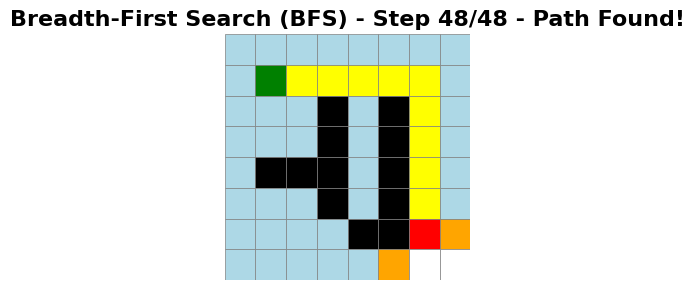

In [4]:
def bfs_search(grid_world, animate=True):
    """
    Breadth-First Search with real-time visualization
    """
    start = grid_world.start
    target = grid_world.target
    
    # Initialize
    queue = deque([start])
    visited = set([start])
    parent = {start: None}
    visited_order = []
    states = []  # For animation
    
    print("BFS Search Started...")
    
    while queue:
        current = queue.popleft()
        visited_order.append(current)
        
        # Store state for animation
        if animate:
            states.append({
                'visited': visited_order.copy(),
                'frontier': list(queue)
            })
        
        # Check if goal reached
        if current == target:
            print(f"Goal reached! Visited {len(visited_order)} nodes")
            
            # Reconstruct path
            path = []
            node = target
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            
            # Calculate cost
            cost = sum(grid_world.get_cost(path[i], path[i+1]) 
                      for i in range(len(path)-1))
            
            print(f"Path length: {len(path)}, Total cost: {cost:.2f}")
            
            if animate:
                grid_world.animate_search(states, path, "Breadth-First Search (BFS)")
            
            return path, cost, len(visited_order)
        
        # Explore neighbors in strict order
        for neighbor in grid_world.get_neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                parent[neighbor] = current
                queue.append(neighbor)
    
    print("No path found!")
    return None, float('inf'), len(visited_order)

# Run BFS
grid_world.reset_grid()
bfs_path, bfs_cost, bfs_nodes = bfs_search(grid_world, animate=True)